# Overview

The aim of my project is to create a model which will predict wine rating based on its description written by a professsional wine-taster. I use the dataset "Wine reviews" from [Kaggle](https://www.kaggle.com/zynicide/wine-reviews). The dataset contains 130k observations scraped from [Wine Enthusiast](https://www.winemag.com/?s=&drink_type=win), a webpage selling wines and rating them. Each observation is a wine rated by Wine Enthusiast's experts. Apart from the rating and description, the dataset contains some other features e.g. country of origin of the wine, its designation, variety and price. In my project I concentrate on NLP analysis of the descriptions and building classification and regression models capable to predict wine rating based on the description. 

Dependent variable( feature "points") can be treated in three distinct ways:

1.   Divided into classes and treated as **nominal** classification target
2.   Divided into classes and treated as **ordinal ** classification target
3.   Left as it is and treated as a regression target.

I will test and compare these three different approaches. For each approach I will built Neural Network (LSTM) and linear model (Logistic or Linear Regression). For nominal classification and regression I will also build XGBoost model. For each model I will do some hyperparameter tuning.

# Import of files and libraries

In [0]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
import string
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from __future__ import print_function
import scipy.stats as ss
from sklearn.externals import joblib
import gensim
from gensim import corpora
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec, word2vec
from gensim.utils import simple_preprocess
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional, MaxPooling1D, Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils, to_categorical 
from keras import regularizers
from keras import backend as K
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import mord

In [0]:
data = pd.read_csv("data/winemag-data-130k-v2.csv", index_col=0)

In [0]:
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In the future it will be exciting to compare predictive power of models based on NLP analysis of wines descriptions and the ones built with the rest of the features from the dataset. It's material for the next project.

# EDA

Dataset contains 129 971 wines descriptions written by 19 wine-tasters. First, let's make sure there are no duplicated records.

In [0]:
# checking for duplicates

for col in data.columns:
  print(f"{col}: {data[col].nunique()}")
print(f"\nNumber of observations: {len(data)}")

country: 43
description: 119955
designation: 37979
points: 21
price: 390
province: 425
region_1: 1229
region_2: 17
taster_name: 19
taster_twitter_handle: 15
title: 118840
variety: 707
winery: 16757

Number of observations: 129971


There are ca. 10 000 wines with the same description in the dataset. It is quite odd as descriptions are detailed and seem to be tailor-made to suit specific wine. It could be the case of duplicated rows or that some wine tasters reuse templates for wine descriptions. The most important thing is to check if the same description corresponds to the same point score. 

In [0]:
# checking if the wines with the same description have the same point score

duplicates = data[["description", "points"]][data.duplicated(subset="description", keep=False)]

counter = 0
for i in range(len(duplicates)):
  duplicated_indexes = np.where(duplicates["description"].iloc[i] == duplicates["description"])
  if duplicates["points"].iloc[duplicated_indexes[0][0]] == duplicates["points"].iloc[duplicated_indexes[0][1]]:
    counter +=1
    
print(counter/len(duplicates))

0.9977029861180465


Conclusion: Almost all duplicated descriptions have the same score, so the rows are true duplicates and can be safely removed.

In [0]:
data = data.drop_duplicates(subset="description")

### Country of wine origin

Reviewed wines come from 43 countries.

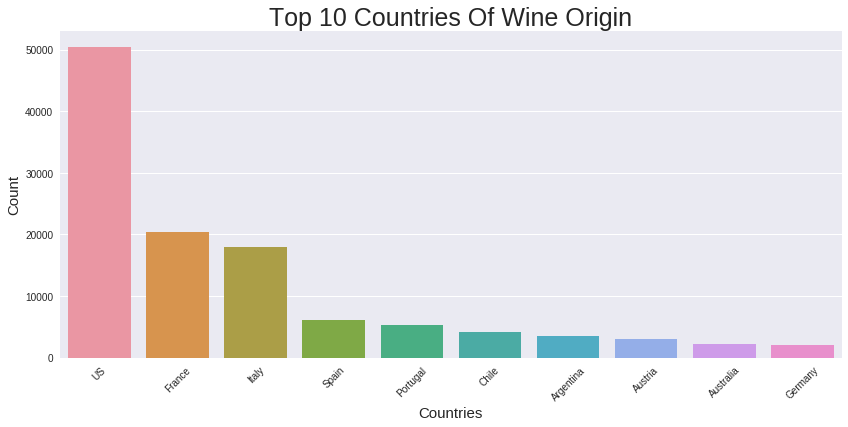

In [0]:
plt.figure(figsize=(14,6))
country = data.country.value_counts()[:10].sort_values(ascending=False)
country_plot = sns.countplot(x='country', data=data[data.country.isin(country.index.values)], order=country.index)
country_plot.set_title("Top 10 Countries Of Wine Origin", fontsize=25)
country_plot.set_xlabel("Countries", fontsize=15)
country_plot.set_ylabel("Count", fontsize=15)
country_plot.set_xticklabels(country.index,rotation=45)
plt.show()

### Variety of wines

There are 707 differenet varieties of wines represented in the dataset.

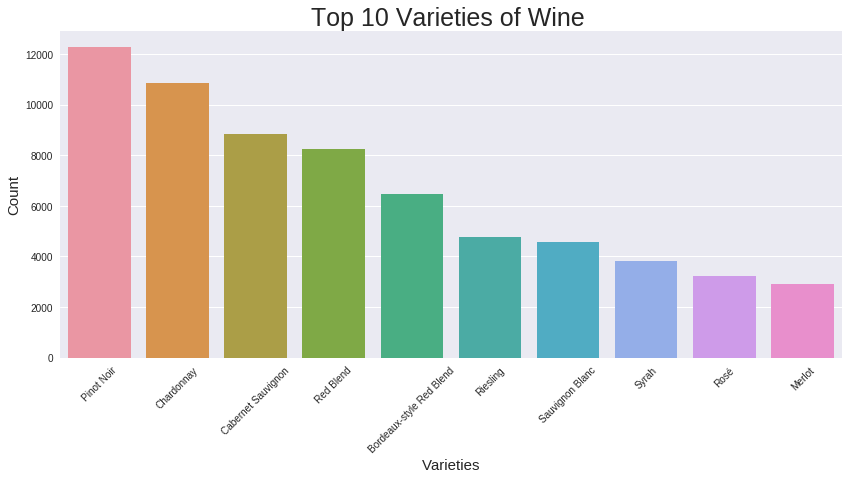

In [0]:
plt.figure(figsize=(14,6))
variety = data.variety.value_counts()[:10]
variety_plot = sns.countplot(x='variety', data=data[data.variety.isin(variety.index.values)], order=variety.index)
variety_plot.set_title("Top 10 Varieties of Wine ", fontsize=25)
variety_plot.set_xlabel("Varieties", fontsize=15)
variety_plot.set_ylabel("Count", fontsize=15)
variety_plot.set_xticklabels(variety.index,rotation=45)
plt.show()

### Points

Percentiles of points: 
0.01    82.0
0.25    86.0
0.50    88.0
0.75    91.0
0.99    95.0
Name: points, dtype: float64


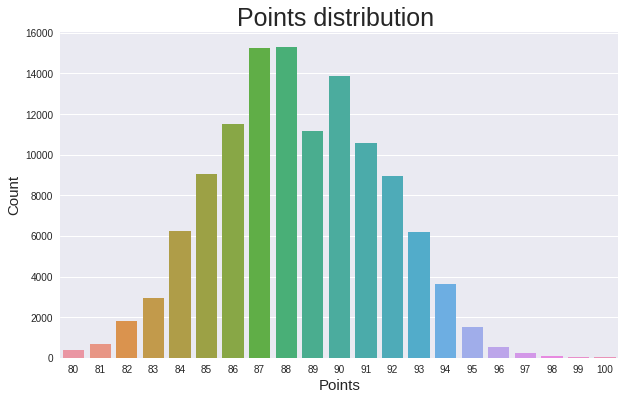

In [0]:
plt.figure(figsize=(10,6))
points_plot = sns.countplot(x='points', data=data)
points_plot.set_title("Points distribution ", fontsize=25)
points_plot.set_xlabel("Points", fontsize=15)
points_plot.set_ylabel("Count", fontsize=15) 

print("Percentiles of points: ") 
print(data['points'].quantile([.01,.25,.5,.75,.99]))

50% of wines scored between 86 and 91 points. Only 1% of wines got less than 82 points (scale beginning with 80) and 1% was above the 95 points threshold. The median is 88 points. Distribution of points is rather normal, a bit left-skewed with lower scores more prevalent than the highest.

### Reviews (feature Description in the dataset)

In [0]:
desc_length = data['description'].apply(len)

print(f"The longest description contains: {desc_length.max()} characters")
print(f"The shortest description contains: {desc_length.min()} characters")
print(f"Median number of characters is: {desc_length.median()}")
print(f"Standard deviation of reviews: {np.std(desc_length)}")
      
      

The longest description contains: 829 characters
The shortest description contains: 20 characters
Median number of characters is: 237.0
Standard deviation of reviews: 67.14651943090978


It's interesting that the length of review is positively correlated with the number of points.

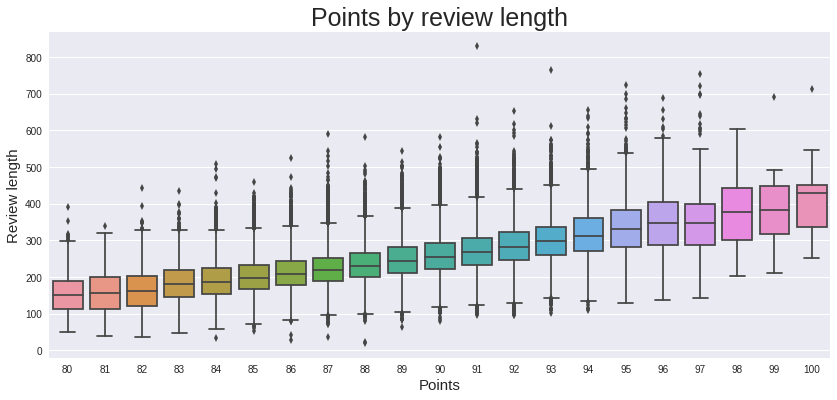

In [0]:
data = data.assign(desc_length = data['description'].apply(len))

plt.figure(figsize=(14,6))
points_length = sns.boxplot(x='points', y='desc_length', data=data)
points_length.set_title('Points by review length', fontsize=25)
points_length.set_ylabel('Review length', fontsize = 15)
points_length.set_xlabel('Points', fontsize = 15) 
plt.show()

WordCloud of reviews shows most common words in reviews excluding stopwords.

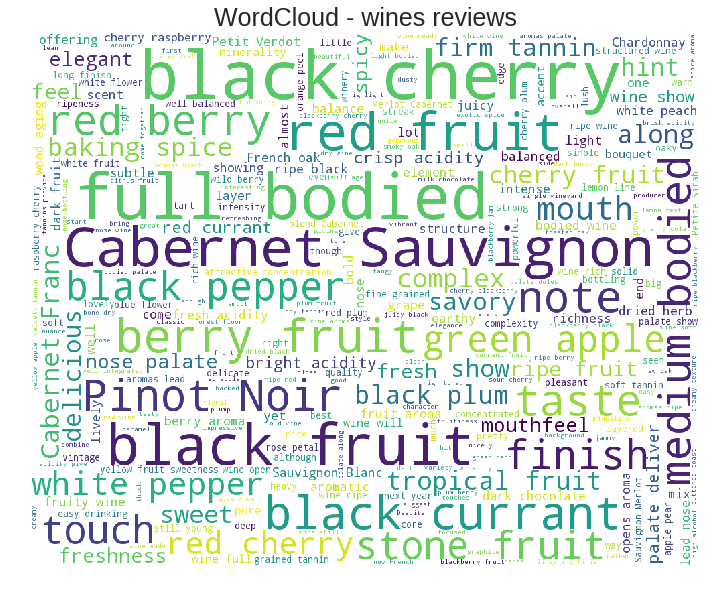

In [0]:
stopwords = set(STOPWORDS)

newStopWords = ["Drink", "now", "offer", "offers", "flavor", "flavors"]

stopwords.update(newStopWords)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=300,
    max_font_size=100, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(data['description']))

print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WordCloud - wines reviews",fontsize=25)
plt.axis('off')
plt.show()

# Assigning variables

In [0]:
X = data["description"]
y = data["points"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                          random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, 
                                                          random_state=52)

# Text preprocessing for LDA

First, in order to conduct topic analysis I have to preprocess reviews of wines:

- make all words lowercase
- remove stopwords
- stem words
- get rid of punctuation



In [0]:
def preprocess_descriptions(X):
  # 1.step: turning all words into lower case
  X_1 = X.str.lower()

  # 2.step: tokenizing descriptions (getting a list of all words used)
  X_2 = X.apply(nltk.word_tokenize)

  # 3.step: removing the stopwords
  stopwords = nltk.corpus.stopwords.words("english")
  X_3 = [[word for word in description if word not in stopwords] for description in X_2]

  # 4.step: stemming the words
  stemmer = nltk.PorterStemmer()
  X_4 = [[stemmer.stem(word) for word in description] for description in X_3]
  
  # 5.step: removing the stopwords again (some words were stemmed to a form of e.g "it", "the"
  # so they will be useless in analysis
  stopwords = nltk.corpus.stopwords.words("english")
  X_5 = [[word for word in description if word not in stopwords] for description in X_4]

  # 6.step: getting rid of punctuation  
  X_6 = [" ".join(word) for word in X_5]
  table = str.maketrans({key: None for key in string.punctuation})
  X_7 = [w.translate(table) for w in X_6]
  
  return X_7

In [0]:
X_train = preprocess_descriptions(X_train)
X_val = preprocess_descriptions(X_val)
X_test = preprocess_descriptions(X_test)

Reviews prepared in such a way are ready to be vectorized. 

I will use CountVectorizer with parameter max_df set to 0.5, which means that it will disregard words that are common to more than half of the reviews. Such words don't convey any unique meaning and don't have predictive power in case of my dataset. I will set min_df=2 as I don't want to take into account words that occured only once as it will lead to overfitting. However, I don't want to get rid of rare words altogether as some points were also very rare (e.g. 100 points) and these words may turn out specific to them.


In [0]:
#Creating vectorized reprezentation of descriptions

tf_vectorizer = CountVectorizer(max_df=0.5, min_df=2)
tf_vectorizer.fit(X_train)
X_train = tf_vectorizer.transform(X_train)
X_val = tf_vectorizer.transform(X_val)
X_test = tf_vectorizer.transform(X_test)

# Topic modelling (Latent Dirichlet Allocation)

My train data set has over 86 000 rows and over 15 000 columns. In order to reduce dimensionality and to extract topics I will use LDA.

In [0]:
# grid searching for best number of topics for LDA model

def find_best_lda_model(document_term_matrix, n_components):
  
  filename = "best_lda_model.joblib"
  
  lda = LatentDirichletAllocation(random_state=32)
  search_params = {'n_components': n_components}
  gs = GridSearchCV(lda, param_grid=search_params)
  gs.fit(document_term_matrix)
  
  joblib.dump(gs.best_estimator_, filename)
  
  print(gs.best_params_)
  
  return gs.best_estimator_
  

In [0]:
best_lda_model = find_best_lda_model(X_train, [3, 5, 7, 10]) # no need to run, best model saved and loaded below

In [0]:
best_lda_model = joblib.load("data/best_lda_model.joblib")

In [0]:
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=32, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [0]:
# X_train, X_val, X_test will be now a matrix of LDA features

X_train_lda = best_lda_model.transform(X_train)
X_val_lda = best_lda_model.transform(X_val)
X_test_lda = best_lda_model.transform(X_test)


It turned out that the best number of topics is 5. Now I will visualize the topics with pyLDAvis.

In [0]:
LDA_vis = pyLDAvis.sklearn.prepare(best_lda_model, X_train, tf_vectorizer)

In [14]:
LDA_vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      24.622065        1       1 -0.007527 -0.201865
3      22.432662        1       2  0.086341  0.025763
4      20.337321        1       3 -0.064625  0.092014
2      18.675758        1       4 -0.185202  0.034186
1      13.932194        1       5  0.171014  0.049902, topic_info=      Category          Freq       Term         Total  loglift  logprob
term                                                                   
2962   Default  20998.000000     cherri  20998.000000  30.0000  30.0000
10039  Default  25103.000000      palat  25103.000000  29.0000  29.0000
1133   Default  27018.000000      aroma  27018.000000  28.0000  28.0000
13709  Default  21784.000000     tannin  21784.000000  27.0000  27.0000
684    Default   8796.000000        age   8796.000000  26.0000  26.0000
1032   Default   9521.000000       appl   9521.000000  25.0000  25.0000
1792   Default  16948.000000      black  16948.000000  24.0000  24.0000
4526   Default  21490.000000      drink  21490.000000  23.0000  23.0000
10212  Default   6100.000000      peach   6100.000000  22.0000  22.0000
1670   Default  11851.000000      berri  11851.000000  21.0000  21.0000
5789   Default   7798.000000     fruiti   7798.000000  20.0000  20.0000
3168   Default   7436.000000      citru   7436.000000  19.0000  19.0000
7820   Default   5862.000000      lemon   5862.000000  18.0000  18.0000
5771   Default  38809.000000      fruit  38809.000000  17.0000  17.0000
5343   Default  26552.000000     finish  26552.000000  16.0000  16.0000
7234   Default  28924.000000         it  28924.000000  15.0000  15.0000
11297  Default  12685.000000        red  12685.000000  14.0000  14.0000
10229  Default   5641.000000       pear   5641.000000  13.0000  13.0000
15321  Default   8133.000000      white   8133.000000  12.0000  12.0000
13279  Default   8562.000000   structur   8562.000000  11.0000  11.0000
3869   Default   8885.000000      crisp   8885.000000  10.0000  10.0000
9697   Default  10751.000000      offer  10751.000000   9.0000   9.0000
11562  Default  14484.000000       rich  14484.000000   8.0000   8.0000
823    Default   3508.000000   alongsid   3508.000000   7.0000   7.0000
576    Default  25830.000000       acid  25830.000000   6.0000   6.0000
9532   Default  16482.000000       note  16482.000000   5.0000   5.0000
2878   Default   5556.000000    charact   5556.000000   4.0000   4.0000
9522   Default  11132.000000       nose  11132.000000   3.0000   3.0000
10613  Default  10186.000000       plum  10186.000000   2.0000   2.0000
2439   Default   7045.000000   cabernet   7045.000000   1.0000   1.0000
...        ...           ...        ...           ...      ...      ...
953     Topic5   1229.324705       anis   1758.082687   1.6132  -5.4794
7914    Topic5   2235.790246    licoric   3982.141336   1.3937  -4.8812
1792    Topic5   6750.110565      black  16948.440465   1.0504  -3.7763
9697    Topic5   4706.863484      offer  10751.204036   1.1450  -4.1368
13709   Topic5   7648.675727     tannin  21784.495043   0.9243  -3.6513
10674   Topic5   1148.824218     polish   1692.554426   1.5835  -5.5471
10297   Topic5   3094.440018     pepper   6681.048730   1.2013  -4.5562
11297   Topic5   4810.139736        red  12685.797182   1.0012  -4.1151
10039   Topic5   7752.170864      palat  25103.520740   0.7959  -3.6378
9791    Topic5   2622.809590       open   5480.051537   1.2341  -4.7216
12934   Topic5   5115.224390      spice  15292.462578   0.8758  -4.0536
1670    Topic5   4274.710162      berri  11851.934925   0.9512  -4.2331
1133    Topic5   7350.759632      aroma  27018.580698   0.6692  -3.6910
14089   Topic5   1836.762755    tobacco   3472.009491   1.3342  -5.0778
5365    Topic5   2387.375644       firm   6210.637734   1.0149  -4.8156
9532    Topic5   3724.127611       note  16482.712384   0.4835  -4.3710
3136    Topic5   1381.135264   cinnamon   2371.7024

Interpretation:
- Default circles represent LDA topics (area of the circles is proportionate to the proportion of all tokens comprised in the topic, e.g topic 1 which is most prevelant includes 24,6% of all tokens).
- Blue bars represent frequency of the terms in the overall corpus (when no circle is selected) or in the specific topic (when a circle is selected). 
- Red bars represent the estimated number of times a given term was generated by a given topic.
- Topic-term circles which appear after selecting a term are proportional to the frequencies with which a given term is estimated to have been generated by the topics.









# Modelling
      

## Nominal Classification

1) classification model: y (points) binned into 3 classes and treated as nominal variable

In [0]:
#bin y into 3 classes of equal size
def bin_y(y):
  return pd.cut(y, [80, 86, 93, 100], labels = [0, 1, 2], right=True, include_lowest=True)

In [0]:
y_train = bin_y(y_train)
y_val = bin_y(y_val)
y_test = bin_y(y_test)

In [0]:
print(f"Number of observations in the classes:\n{bin_y(y).value_counts()}")

Number of observations in the classes:
1    81265
0    32674
2     6016
Name: points, dtype: int64


I'm aware that the classes of y are imbalanced. However, I decided to go with it because another option, which was equal-frequency binning gave the following bins:

In [0]:
equal_frequency = pd.qcut(y, 3, labels = [0, 1, 2])
print(f"Points in the first bin: {np.sort(y[ef==0].unique())}")
print(f"Points in the second bin: {np.sort(y[ef==1].unique())}")
print(f"Points in the third bin: {np.sort(y[ef==2].unique())}")

Points in the first bin: [80 81 82 83 84 85 86 87]
Points in the second bin: [88 89 90]
Points in the third bin: [ 91  92  93  94  95  96  97  98  99 100]


I don't think it's practical to discern between such imbalanced sized bins as: 88-90 and 91-100 points wines. 

### Logistic Regression and XGBoost

First I will search for the best parameters for Logistic Regression and XGBoost, fit both models with best parameters and save them to a file.

In [0]:
best_logisticregression = "best_logisticregression.joblib" 
best_xgboost = "best_xgboost.joblib"


models = [LogisticRegression(), XGBClassifier(objective="multi:softmax", num_class=3)]

param_grids = [
    {"penalty": ["l1","l2"], 
     "C": ss.uniform(0.01,1)},
    
          {"n_estimators":ss.randint(10,300),
           "learning_rate":ss.uniform(0.01,0.3),
           "max_depth": ss.randint(5,30),
           "min_child_weight":ss.randint(5,50),
           "reg_lambda":ss.uniform(0.1,3)}
]


best_estimators =[]

for model, param_grid in zip(models, param_grids):
    
    cv = RandomizedSearchCV(cv=5, 
                        estimator=model,
                        param_distributions=param_grid,
                        n_iter=30,
                        verbose=2)
    cv.fit(X_train_lda, y_train)
    
    best_estimators.append(cv.best_estimator_)
    
    print(accuracy_score(cv.best_estimator_.predict(X_val_lda),y_val),
         cv.best_params_)
    

joblib.dump(best_estimators[0], best_logisticregression, compress=True)
joblib.dump(best_estimators[1], best_xgboost, compress=True)

In [0]:
best_logistic_regression = joblib.load("data/best_logisticregression.joblib")
best_xgbclassifier = joblib.load("data/best_xgbclassifier.joblib")
print(f"Accuracy score for Logistic Regression: {accuracy_score(best_logistic_regression.predict(X_val_lda),y_val)}")
print(f"Accuracy score for XGBoostClassifier: {accuracy_score(best_xgbclassifier.predict(X_val_lda),y_val)}")

Accuracy score for Logistic Regression: 0.6726381170317097
Accuracy score for XGBoostClassifier: 0.7367767244197451


### LSTM

#### Text preprocessing for LSTM

In [0]:
# reapplying split on X
X_train, X_test= train_test_split(X, test_size=0.15, 
                                                          random_state=42)
X_train, X_val= train_test_split(X_train, test_size=0.15, 
                                                          random_state=52)

# tokenizing and filtering out basic punctuation and setting to lowercase
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# dictionary mapping words (str) to their index (int)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")
print(word_index)

# turning texts into sequences (list of word indexes)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

# checking the length of the longest review
max_len = max([len(x) for x in sequences_train+sequences_val+sequences_test])
print(f"The longest description has {max_len} words.")

# padding sequences so that they are of equal length
X_train_nn = sequence.pad_sequences(sequences_train, max_len)
X_test_nn = sequence.pad_sequences(sequences_test, max_len)
X_val_nn = sequence.pad_sequences(sequences_val, max_len)

In [0]:
# turning y into one-hots
nb_classes=3
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
y_val = np_utils.to_categorical(y_val, nb_classes)

#### Preparing pre-trained Embeddings

I will use pre-trained Glove embeddings.

First I loaded the smallest Glove Embedding  model with 400 000 embeddings. As wines descriptions include some not-so-common word I checked if the vocabulary of the model is not to small. 68% of the vocabulary from wine reviews is coverd in the smallest Glove Model. So I tried bigger models. Best coverage was for the model with 1,9 M vocabulary - 75%. It's not perfect, but I will give it a try.

In [0]:
# code to download, unzip, preprocess and load pre-trained Glove model with embeddings
# I saved an array of filetered embeddings and load it below 

!wget http://nlp.stanford.edu/data/glove.42B.300d.zip
!unzip glove.42B.300d.zip

def load_glove_model(glove_input_file, word2vec_output_file="/final_project/gensim_glove_vectors.txt"):
  glove2word2vec(glove_input_file, word2vec_output_file)
  return KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
glove_model = load_glove_model("glove.42B.300d.txt")

# creating embedding matrix containing only embeddings for words used in wines reviews

emb_matrix = np.zeros((len(word_index), 300))
for w, i in word_index.items():
  try:
    vect = glove_model[w]
    if vect is not None:
      emb_matrix[i] = vect
  except:
    pass

joblib.dump(emb_matrix, "emb_matrix.joblib")

In [0]:
# checking how many words from wines reviews are reprezented in pre-trained Glove Embeddings
print(len(([key for key in word_index.keys() if key in glove_model]))/len(word_index))

0.7513528471282745


In [0]:
emb_matrix = joblib.load("data/emb_matrix.joblib")

#### Learning model

Now prepared texts and embeddings can be fed into Neural Network. I test several architectures for LSTM network.



In [0]:
def build_lstm_model_1(list_of_layers):
  
  model = Sequential()
  model.add(Embedding(emb_matrix.shape[0],
                      emb_matrix.shape[1], 
                      input_length=max_len,
                      weights = [emb_matrix], 
                      trainable = False))
  for layer in list_of_layers:
    model.add(layer)
  model.summary() 
  
  model.compile(loss="categorical_crossentropy",
               optimizer="adam", 
               metrics=["categorical_accuracy"])
  return model

In [0]:
def evaluate_lstm_model(model, X_train, X_val, y_train, y_val, filename, batch_size=128):

  early_stopping = EarlyStopping(patience=3, monitor="val_loss")
  take_best_model = ModelCheckpoint(str(filename)+".h5py", save_best_only=True)

  model.fit(X_train, y_train, epochs=100, validation_split=0.2,
           batch_size=batch_size, 
           callbacks=[early_stopping, take_best_model])

  model.load_weights(str(filename)+".h5py")
  return model.evaluate(X_val, y_val)[1]

In [0]:
models = {        
          "clf_LSTM_300n":      [LSTM(300),
                                  Dense(3, activation="softmax")],
    
          "clf_LSTM_500n":      [LSTM(500),
                                  Dense(3, activation="softmax")],
    
          "clf_LSTM_1000n":      [LSTM(1000),
                                  Dense(3, activation="softmax")],
          
          "clf_BiLSTM_Dense":          [Bidirectional(LSTM(100)),
                                  Dense(3, activation="softmax")],
          
          "clf_MultipleLSTM_Dense":    [LSTM(200, return_sequences=True),
                                  LSTM(100),
                                  Dense(3, activation="softmax")],
          
          "clf_LSTM_MultipleDense":     [LSTM(100),
                                  Dense(30, activation="relu"),
                                  Dense(3, activation="softmax")],
     
         
          "clf_Conv_Pool_LSTM_Dense": [Conv1D(32,3),
                                   MaxPooling1D(pool_size=2),
                                   LSTM(100),
                                   Dense(3, activation="softmax")],
}



In [0]:
lst = []
for model, params in models.items():
  acc = (evaluate_lstm_model(build_lstm_model_1(params), X_train_nn, X_val_nn, y_train, y_val, model))
  lst.append(acc)

In [0]:
lstm_1_results = pd.DataFrame(list(zip(models.keys(), lst)), columns=["model", "accuracy"]).sort_values(by="accuracy", ascending=False).reset_index(drop=True)
print(lstm_1_results)

In [0]:
lstm_1_results

,model,accuracy
0,clf_LSTM_MultipleDense,0.818830
1,clf_LSTM_300n,0.817980
2,clf_LSTM_1000n,0.817914
3,clf_MultipleLSTM_Dense,0.817784
4,clf_BiLSTM_Dense,0.817522
5,clf_LSTM_500n,0.816999
6,clf_Conv_Pool_LSTM_Dense,0.808500


### Score on test set

The best model of all models tested for nominal classification is neural network with LSTM layer with 100 neurons, Dense layer with 30 neurons and output Dense layer. Let's check how it scores on test set.

In [0]:
# loading best model from a file and evaluating on test set

best_nom_clf = build_lstm_model_1(models["clf_LSTM_MultipleDense"])
best_nom_clf.load_weights("data/best_nn_nom_clf.h5py")
best_nom_clf.compile(loss="categorical_crossentropy",
               optimizer="adam", 
               metrics=["categorical_accuracy"])
best_nom_acc = best_nom_clf.evaluate(X_test_nn, y_test)[1]
print(f"Accuracy of best model for nominal classification: {best_nom_acc}")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 136, 300)          9757200   
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_14 (Dense)             (None, 30)                3030      
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 93        
Total params: 9,920,723
Trainable params: 163,523
Non-trainable params: 9,757,200
_________________________________________________________________
17994/17994 [==============================] - 65s 4ms/step
Accuracy of best model for nominal classification: 0.820162276320952


## Ordinal Classification

1) ordinal classification model: y (points) binned into 3 classes and treated as ordinal variable

Taking into account that winemag.com publishes only reviews of wines over 80 points, classes in this approach could be understood as follows: 0 - average, 1- good, 2 - excellent.

### Logistic Regression using mord package

My first approach will be to use mord package, which "is a Python package that implements some ordinal regression methods following the scikit-learn API." (*mord 0.3 documentation*). I will use mord implementation of Logistic Regression for ordinal classification. The only hyperparameter that can be tuned is alpha, which is L2 regularization parameter.

In [0]:
param = {"alpha": [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]}
gs = GridSearchCV(mord.LogisticIT(), param, cv=5, scoring="accuracy")
gs.fit(X_train_lda, y_train)
y_pred = gs.best_estimator_.predict(X_val_lda)
print("Ordinal Logistic Regression:")
print(f"Best regularization parameter: {gs.best_params_}")
print(f"Accuracy score: {accuracy_score(y_val, y_pred)}")

Ordinal Logistic Regression:
Best regularization parameter: {'alpha': 0.01}
Accuracy score: 0.6726381170317097


That's an interesting result. Ordinal Logistic Regression scored exacty the same as Logistic Regression for nominal classification. It is most probably coincidence but it shows that mord implementaction of Ordinal Logistic Regression doesn't improve the results. Maybe due to the lack of hyperparameters to tune.

### NNRank

I build neural network architecture for ordinal classification (NNRank) basing on "A Neural Network Approach to Ordinal Regression" J.Chen, Z.Wang, G.Pollastri. Most important differences from standard neural network for classification include:

- **target vector encoding:** "If a data point x belongs to category k, it is classified
automatically into lower-order categories (1, 2, ..., k − 1) as
well. So the target vector of x is t = (1, 1, .., 1, 0, 0, 0),
where ti (1 ≤ i ≤ k) is set to 1 and other elements
zeros" (*ibid.)*

- **output layer:** number of nodes is equal to number of classes. However, instead of softmax function used in nominal classification, the authors used sigmoid function for each node so that it doesn't include the outputs from other nodes. Each output node calculates the probability of a data point belonging to class k independently.

Because of the specific target encoding I can't use categorical or binary accuracy from keras metrics. I also can't use predict_classes method as it isn't suited for a situation where the probability in more than one output node is above the threshold (eg. >0.5). In order to calculate the true accuracy I have to bring the prediction probabilities vector for every data point back to the categorical encoding and compare the classes with y_val in the same encoding format. So I created **custom keras metric "ordinal_accuracy".**



In [0]:
# encoding y so that the net learn the orderings
# function takes binned y variable as input

def make_ordinal_encoding(y):
  ordinal= np.zeros((y.shape[0], 3), dtype=int)
  ordinal[np.arange(y.shape[0]), y] = 1
  ordinal[ordinal[:, 1] == 1, 0] = 1
  ordinal[ordinal[:, 2] == 1, 0] = 1
  ordinal[ordinal[:, 2] == 1, 1] = 1
  return ordinal

In [0]:
y_train_ord = make_ordinal_encoding(y_train)
y_val_ord = make_ordinal_encoding(y_val)
y_test_ord = make_ordinal_encoding(y_test)

In [0]:
# defining custom keras metric to calculate ordinal_accuracy

def ordinal_accuracy(y_true, y_pred):
  y_pred_labels = K.round(y_pred)   # bringing probability output to ordinal encoding form
  y_pred_class = K.sum(y_pred_labels, axis=-1)  # getting categorical class (actually class+1)
  y_true_class = K.sum(y_true, axis=-1)         
  return K.cast(K.equal(y_true_class, y_pred_class), K.floatx())

In [0]:
def build_lstm_model_2(list_of_layers):
  
  model = Sequential()
  model.add(Embedding(emb_matrix.shape[0],
                      emb_matrix.shape[1], 
                      input_length=max_len,
                      weights = [emb_matrix], 
                      trainable = False))
  for layer in list_of_layers:
    model.add(layer)
  model.summary() 
  
  model.compile(loss="mean_squared_error",
               optimizer="adam", 
               metrics=[ordinal_accuracy])
  return model

In [0]:
models = {        
          "ord_LSTM_300neurons":      [LSTM(300),
                                  Dense(3, activation="sigmoid")],
    
          "ord_LSTM_500neurons":      [LSTM(500),
                                  Dense(3, activation="sigmoid")],
    
          "ord_LSTM_1000neurons":      [LSTM(1000),
                                  Dense(3, activation="sigmoid")],        
          
          "ord_BiLSTM_Dense":          [Bidirectional(LSTM(300)),
                                  Dense(3, activation="sigmoid")],
          
          "ord_MultipleLSTM_Dense":    [LSTM(200, return_sequences=True),
                                  LSTM(100),
                                  Dense(3, activation="sigmoid")],
          
          "ord_LSTM_MultipleDense":     [LSTM(300),
                                  Dense(30, activation="relu"),
                                  Dense(3, activation="sigmoid")],
     
         
          "ord_Conv_Pool_LSTM_Dense": [Conv1D(32,3),
                                   MaxPooling1D(pool_size=2),
                                   LSTM(100),
                                   Dense(3, activation="sigmoid")]
}

In [0]:
lst = []
for model, params in models.items():
  acc = (evaluate_lstm_model(build_lstm_model_2(params), X_train_nn, X_val_nn, y_train_ord, y_val_ord, model))
  lst.append(acc)

In [0]:
lstm_2_results = pd.DataFrame(list(zip(models.keys(), lst)), columns=["model", "accuracy"]).sort_values(by="accuracy", ascending=False).reset_index(drop=True)

In [0]:
lstm_2_results

,model,accuracy
0,ord_MultipleLSTM_Dense,0.820137
1,ord_LSTM_MultipleDense,0.819941
2,ord_LSTM_500neurons,0.819483
3,ord_LSTM_1000neurons,0.818830
4,ord_LSTM_300neurons,0.816476
5,ord_BiLSTM_Dense,0.816280
6,ord_Conv_Pool_LSTM_Dense,0.804904


### Score on test set

The best model for ordinal classification is the neural net with two LSTM layers (200 and 100 neurons) and a Dense layer. Let's check how it scores on the test set.

In [0]:
# loading best model from a file and evaluating on test set

best_ord_clf = build_lstm_model_2(models["ord_MultipleLSTM_Dense"])
best_ord_clf.load_weights("data/best_nn_nom_ord.h5py")
best_ord_clf.compile(loss="mean_squared_error",
               optimizer="adam", 
               metrics=[ordinal_accuracy])
best_ord_acc = best_ord_clf.evaluate(X_test_nn, y_test_ord)[1]
print(f"Accuracy of the best model for ordinal classification: {best_ord_acc}")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 136, 300)          9757200   
_________________________________________________________________
lstm_5 (LSTM)                (None, 136, 200)          400800    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 10,278,703
Trainable params: 521,503
Non-trainable params: 9,757,200
_________________________________________________________________
17994/17994 [==============================] - 125s 7ms/step
Accuracy of the best model for ordinal classification: 0.8179948871713671


## Regression

3) Keeping target variable in its original form (points on scale 80-100).

In [0]:
y_train, y_test = train_test_split(y, test_size=0.15, 
                                                    random_state=42)
y_train, y_val = train_test_split(y_train, test_size=0.15, 
                                                          random_state=52)

### Linear Regression and XGBoost

First I will search for the best parameters for Linear Regression and XGBoost. Both models will be learned on the dataset transformed so that it contains LDA features.

In [0]:
model_linear_reg = LinearRegression()
model_linear_reg.fit(X_train_lda, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [0]:
best_xgb = "best_xgbregressor.joblib"


model = XGBRegressor(scoring="mean_squared_error")

param_grid = {"n_estimators":ss.randint(100,300),
           "learning_rate":ss.uniform(0.01,0.3),
           "max_depth": ss.randint(5,30),
           "min_child_weight":ss.randint(1,50),
           "reg_lambda":ss.uniform(0.1,3)}
    
cv = RandomizedSearchCV(cv=5, 
                        estimator=model,
                        param_distributions=param_grid,
                        n_iter=30,
                        verbose=2)
cv.fit(X_train_lda, y_train)
    
joblib.dump(cv.best_estimator_, best_xgb)
    
print(mean_squared_error(y_val, cv.best_estimator_.predict(X_val_lda)),
         cv.best_params_)

In [0]:
best_xgbregressor = joblib.load("data/best_xgbregressor.joblib")

In [0]:
print("Linear Regression:")
print(f"MSE: {mean_squared_error(y_val, model_linear_reg.predict(X_val_lda))}")
print(f"MAE: {mean_absolute_error(y_val, model_linear_reg.predict(X_val_lda))}")
print(f"R2: {r2_score(y_val, model_linear_reg.predict(X_val_lda))}\n")

print("XGBRegressor: ")
print(f"MSE: {mean_squared_error(y_val, best_xgbregressor.predict(X_val_lda))}")
print(f"MAE: {mean_absolute_error(y_val, best_xgbregressor.predict(X_val_lda))}")
print(f"R2: {r2_score(y_val, best_xgbregressor.predict(X_val_lda))}")

Linear Regression:
MSE: 9.170182637761958
MAE: 2.481524807848
R2: 0.03655666894855314

XGBRegressor: 
MSE: 5.690265062135028
MAE: 1.9028470386356728
R2: 0.4021658954257188


XGBRegressor scored better than Linear Regression. The results for XGBRegressor are rather satisfactory. Mean absolute error is 1,9 point whereas the scale comprises 20 points, so it's less than 10%. R2 maybe doesn't look amazing with 40% of variance in points explained by the model, but taking into account that rating of wine is quite subjective, the score is decent. 

**Comparing classification and regression results**


In order to compare classification and regression results, I calculate accuracy for regression in the following way: for each prediction from regression model I indicate the class to which it would belong based on the bins used for classification. In the same way I bin y_test. Thaks to this trick I can calculate the accuracy and compare it with the accuracy of the classification models.

In [0]:
# function to calculate accuracy for regression models

def calculate_regression_accuracy(bin_y, X, y, model):
  reg_acc = accuracy_score(bin_y(y), bin_y(model.predict(X).flatten()))
  return reg_acc

In [0]:
linear_reg_acc = calculate_regression_accuracy(bin_y, X_val_lda, y_val, model_linear_reg)
print(f"Accuracy of Linear Regression: {linear_reg_acc}")

Accuracy of Linear Regression: 0.6726381170317097


In [0]:
xgb_reg_acc = calculate_regression_accuracy(bin_y, X_val_lda, y_val, best_xgbregressor)
print(f"Accuracy of XGBRegressor: {xgb_reg_acc}")

Accuracy of XGBRegressor: 0.7289310232101994


### LSTM

As in classification I will use pre-trained Glove Embeddings with 1.9 M vocabulary. 

In [0]:
def build_lstm_model_3(list_of_layers):
  
  model = Sequential()
  model.add(Embedding(emb_matrix.shape[0],
                      emb_matrix.shape[1], 
                      input_length=max_len,
                      weights = [emb_matrix], 
                      trainable = False))
  for layer in list_of_layers:
    model.add(layer)
  model.summary() 
  
  model.compile(loss='mean_squared_error',
               optimizer="adam", 
               metrics=["mean_absolute_error"])
  return model

In [0]:
models =  {       
          "LSTM_300neurons":      [LSTM(300),
                                  Dense(1)],
    
          "LSTM_500neurons":      [LSTM(500),
                                  Dense(1)],
        
          "LSTM_1000neurons":      [LSTM(1000),
                                  Dense(1)],
          
          "BiLSTM_Dense":          [Bidirectional(LSTM(300)),
                                  Dense(1)],
          
          "MultipleLSTM_Dense":    [LSTM(200, return_sequences=True),
                                  LSTM(100),
                                  Dense(1)],
          
          "LSTM_MultipleDense":     [LSTM(300),
                                  Dense(30, activation="relu"),
                                  Dense(1)],
     
         
          "Conv_Pool_LSTM_Dense": [Conv1D(32,3),
                                   MaxPooling1D(pool_size=2),
                                   LSTM(100),
                                   Dense(1)]
}

In [0]:
lst = []
for model, params in models.items():
  mae = (evaluate_lstm_model(build_lstm_model_3(params), X_train_nn, X_val_nn, y_train, y_val, model))
  lst.append(mae)

In [0]:
lstm_3_results = pd.DataFrame(list(zip(models.keys(), lst)), columns=["model", "MSE"]).sort_values(by="MSE", ascending=True).reset_index(drop=True)

In [0]:
lstm_3_results

,model,MSE
0,LSTM_300neurons,9.518730
1,LSTM_MultipleDense,9.520288
2,Conv_Pool_LSTM_Dense,9.521109
3,BiLSTM_Dense,9.521109
4,MultipleLSTM_Dense,9.523565
5,LSTM_500neurons,9.526321
6,LSTM_1000neurons,9.526927


In [0]:
# loading best NN regression model and calculating accuracy

best_nn_reg = build_lstm_model_3(models["LSTM_300neurons"])
best_nn_reg.load_weights("data/LSTM_300neurons.h5py")
best_nn_reg.compile(loss='mean_squared_error',
               optimizer="adam", 
               metrics=["mean_absolute_error"])
nn_reg_acc = calculate_regression_accuracy(bin_y, X_val_nn, y_val, best_nn_reg)
print(f"Accuracy of best NN for regression: {nn_reg_acc}")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 136, 300)          9757200   
_________________________________________________________________
lstm_17 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 301       
Total params: 10,478,701
Trainable params: 721,501
Non-trainable params: 9,757,200
_________________________________________________________________
Accuracy of best NN for regression: 0.6726381170317097


All of the LSTM models has very similar MSE value. The best model (lowest MSE) is the simplest: LSTM network with 300 neurons. However, MSE is higher than for both Linear Regression (minimal difference) and for XBGRegressor, which is clear winner with MSE 5,7. It has also the highest accuracy: 0.73.

### Score on test set

The best model of all models tested for regression is XGBRegressor. Let's check how it scores on test set.

In [0]:
# loading best model from a file and evaluating on test set

best_reg_acc = calculate_regression_accuracy(bin_y, X_test_lda, y_test, best_xgbregressor)
print(f"Accuracy of best model for regression: {best_reg_acc}")


Accuracy of best model for regression: 0.7300211181504946


# Summary

Predicting wine rating on the basis of its description can be treated in three ways: as Nominal Classification, Ordinal Classification and Regression. It turned out that LSTM for Nominal Classification and NNRank for Ordinal Classification scored almost the same (nominal slightly better) leaving Regression behind. It's an interesting result as I supposed that taking into accound ordinality of classes would improve the accuracy. However, it seems that in this particular problem the effect of ordinality wasn't that big.

Table below shows best model for every approach and its accuracy on test set.

There were two things that surprised me during this project. First, that the terms used by professional sommeliers and wine-tasters to describe wines are not as random as they appeared to me before and they are actually good predictors for wine quality (supposing rating reflects wine quality). Second is the fact that there are so few Python implementations for Ordinal Classification. It seems like a field for further research.




In [0]:
pd.DataFrame(data = {"approach": ["Nominal Classification", "Ordinal Classification", "Regression"],
              "models": ["LSTM(300)+Dense(30)+Dense(3)", "LSTM(200)+LSTM(100)+Dense(3) ", "XGBREgressor"],
               "accuracy": [best_nom_acc, best_ord_acc, best_reg_acc]})

,accuracy,approach,models
0,0.820162,Nominal Classification,LSTM(300)+Dense(30)+Dense(3)
1,0.817995,Ordinal Classification,LSTM(200)+LSTM(100)+Dense(3)
2,0.730021,Regression,XGBREgressor
